In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


In [29]:
# 1.2 Feature creation libraries
from sklearn.random_projection import SparseRandomProjection as sr  # Projection features
from sklearn.cluster import KMeans                    # Cluster features
from sklearn.preprocessing import PolynomialFeatures  # Interaction features

# 1.3 For feature selection
# Ref: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif  # Selection criteria

# 1.4 Data processing
# 1.4.1 Scaling data in various manner
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
# 1.4.2 Transform categorical (integer) to dummy
from sklearn.preprocessing import OneHotEncoder

# 1.5 Splitting data
from sklearn.model_selection import train_test_split

# 1.6 Decision tree modeling
# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree
# http://scikit-learn.org/stable/modules/tree.html#tree
from sklearn.tree import  DecisionTreeClassifier as dt

# 1.7 RandomForest modeling
from sklearn.ensemble import RandomForestClassifier as rf

# 1.8 Plotting libraries to plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# 1.9 Misc
import os, time, gc

In [30]:
# 2.1 Read train/test files
heart = pd.read_csv("../input/heart.csv") #Loading of Data

# 2.2 Look at data
heart.head(2)
heart.shape                        



(303, 14)

In [31]:
# 3. split the data
X_train, X_test, y_train, y_test = train_test_split(heart.drop('target', 1), heart['target'], test_size = 0.3, random_state=10) 

# Check the splits
X_train.shape       # 212 X 13
X_test.shape        #  91 X 13
y_train.shape       # (212,)
y_test.shape        # ( 91,)


# Check if there are Missing values? None
X_train.isnull().sum().sum()  # 0
X_test.isnull().sum().sum()   # 0

0

In [32]:
#  4. Feature 1: Row sums of features 1:13. More successful
#                when data is binary.

X_train['sum'] = X_train.sum(numeric_only = True, axis=1)  # numeric_only= None is default
X_test['sum'] = X_test.sum(numeric_only = True,axis=1)

# 4.1 Assume that value of '0' in a cell implies missing feature
#     Transform train and test dataframes
#     replacing '0' with NaN
#     Use pd.replace()
tmp_train = X_train.replace(0, np.nan)
tmp_test = X_test.replace(0,np.nan)

# 4.2 Check if tmp_train is same as train or is a view
#     of train? That is check if tmp_train is a deep-copy

tmp_train is X_train                # False
#tmp_train is train.values.base    # False
tmp_train._is_view                # False

False

In [33]:
# 4.3 Check if 0 has been replaced by NaN
tmp_train.head(1)
tmp_test.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sum
246,56,NaN,NaN,134,409,NaN,NaN,150,1.0,1.9,1.0,2.0,3,757.9


In [34]:
# 5. Feature 2 : For every row, how many features exist
#                that is are non-zero/not NaN.
#                Use pd.notna()
tmp_train.notna().head(1)
X_train["count_not0"] = tmp_train.notna().sum(axis = 1)
X_test['count_not0'] = tmp_test.notna().sum(axis = 1)

In [35]:
# 6. Similary create other statistical features
#    Feature 3
#    Pandas has a number of statistical functions
#    Ref: https://pandas.pydata.org/pandas-docs/stable/reference/frame.html#computations-descriptive-stats

feat = [ "var", "median", "mean", "std", "max", "min"]
for i in feat:
    X_train[i] = tmp_train.aggregate(i,  axis =1)
    X_test[i]  = tmp_test.aggregate(i,axis = 1)

In [36]:
# 7 Delete not needed variables and release memory
del(tmp_train)
del(tmp_test)
gc.collect()


# 8. So what do we have finally
X_train.shape                # 212 X (13 + 8)
X_train.head(1)
X_test.shape                 #  91 X (13 + 8)
X_test.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sum,count_not0,var,median,mean,std,max,min
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3,757.9,10,61726.561778,29.5,151.580000,248.448308,757.9,1.0
183,58,1,2,112,230,0,0,165,0,2.5,1,1,3,575.5,11,30681.904545,3.0,104.636364,175.162509,575.5,1.0


In [37]:
# 8. Store column names of our data somewhere
#     We will need these later (at the end of this code)
colNames = X_train.columns.values
colNames

array(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'sum',
       'count_not0', 'var', 'median', 'mean', 'std', 'max', 'min'],
      dtype=object)

In [38]:
################ Feature creation Using Random Projections ##################
# 9. Random projection is a fast dimensionality reduction feature
#     Also used to look at the structure of data

# 10. Generate features using random projections
#     First stack train and test data, one upon another
tmp = pd.concat([X_train,X_test],
                axis = 0,            # Stack one upon another (rbind)
                ignore_index = True
                )


# 10.1
tmp.shape     # 303 X 21

(303, 21)

In [41]:

# 10.2 Transform tmp t0 numpy array
#      Henceforth we will work with array only
tmp = tmp.values
tmp.shape       # (303, 21)

(303, 21)

In [42]:
# 11. Let us create 5 random projections/columns
#     This decision, at present, is arbitrary
NUM_OF_COM = 5

# 11.1 Create an instance of class
rp_instance = sr(n_components = NUM_OF_COM)

# 11.2 fit and transform the (original) dataset
#      Random Projections with desired number
#      of components are returned
rp = rp_instance.fit_transform(tmp[:, :13])

# 11.3 Look at some features
rp[: 5, :  3]


# 11.4 Create some column names for these columns
#      We will use them at the end of this code
rp_col_names = ["r" + str(i) for i in range(5)]
rp_col_names

['r0', 'r1', 'r2', 'r3', 'r4']

In [43]:
############################ Feature creation using kmeans ####################
######################Can be skipped without loss of continuity################

# 12. Before clustering, scale data
# 12.1 Create a StandardScaler instance
se = StandardScaler()
# 12.2 fit() and transform() in one step
tmp = se.fit_transform(tmp)
# 12.3
tmp.shape               # 303 X 21 (an ndarray)


(303, 21)

In [44]:
# 13. Perform kmeans using 13 features.
#     No of centroids is no of classes in the 'target'
centers = y_train.nunique()    # 2 unique classes
centers 

2

In [45]:
# 14.1 Begin clustering
start = time.time()

# 14.2 First create object to perform clustering
kmeans = KMeans(n_clusters=centers, # How many
                n_jobs = 2)         # Parallel jobs for n_init



# 14.3 Next train the model on the original data only
kmeans.fit(tmp[:, : 13])

end = time.time()
(end-start)/60.0 

0.03480234940846761

In [46]:
# 15 Get clusterlabel for each row (data-point)
kmeans.labels_
kmeans.labels_.size   # 303

303

In [47]:
# 16. Cluster labels are categorical. So convert them to dummy

# 16.1 Create an instance of OneHotEncoder class
ohe = OneHotEncoder(sparse = False)

# 16.2 Use ohe to learn data
#      ohe.fit(kmeans.labels_)
ohe.fit(kmeans.labels_.reshape(-1,1))     # reshape(-1,1) recommended by fit()
                                          # '-1' is a placeholder for actual
# 16.3 Transform data now
dummy_clusterlabels = ohe.transform(kmeans.labels_.reshape(-1,1))
dummy_clusterlabels
dummy_clusterlabels.shape    # 303 X 2 (as many as there are classes)

# 16.4 We will use the following as names of new nine columns
#      We need them at the end of this code

k_means_names = ["k" + str(i) for i in range(2)]
k_means_names

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


['k0', 'k1']

In [48]:
############################ Interaction features #######################
# 15. Will require lots of memory if we take large number of features
#     Best strategy is to consider only impt features

degree = 2
poly = PolynomialFeatures(degree,                 # Degree 2
                          interaction_only=True,  # Avoid e.g. square(a)
                          include_bias = False    # No constant term
                          )


# 15.1 Consider only first 5 features
#      fit and transform
df =  poly.fit_transform(tmp[:, : 5])


df.shape     # 303 X 15

(303, 15)

In [49]:
# 15.2 Generate some names for these 15 columns
poly_names = [ "poly" + str(i)  for i in range(15)]
poly_names

['poly0',
 'poly1',
 'poly2',
 'poly3',
 'poly4',
 'poly5',
 'poly6',
 'poly7',
 'poly8',
 'poly9',
 'poly10',
 'poly11',
 'poly12',
 'poly13',
 'poly14']

In [50]:
################# concatenate all features now ##############################

# 16 Append now all generated features together
# 16 Append random projections, kmeans and polynomial features to tmp array

tmp.shape          # 303 X 21

#  16.1 If variable, 'dummy_clusterlabels', exists, stack kmeans generated
#       columns also else not. 'vars()'' is an inbuilt function in python.
#       All python variables are contained in vars().

if ('dummy_clusterlabels' in vars()):               #
    tmp = np.hstack([tmp,rp,dummy_clusterlabels, df])
else:
    tmp = np.hstack([tmp,rp, df])       # No kmeans      <==


tmp.shape          # 303 X 43   If no kmeans: (303, 21)

# 16.2 Separate train and test
X = tmp[: X_train.shape[0], : ]
X.shape                             # 212 X 43 if no kmeans: (212, 21)

# 16.3
test = tmp[X_train.shape[0] :, : ]
test.shape                         #  91 X 43; if no kmeans: (91, 21)

# 16.4 Delete tmp
del tmp
gc.collect()

493

In [51]:
################## Model building #####################


# 17. Split train into training and validation dataset
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y_train,
                                                    test_size = 0.3)

In [52]:
X_train.shape 

(148, 43)

In [53]:
X_test.shape 

(64, 43)

In [54]:
# 18 Decision tree classification
# 18.1 Create an instance of class
clf = dt(min_samples_split = 5,
         min_samples_leaf= 5
        )

start = time.time()
# 18.2 Fit/train the object on training data
#      Build model
clf = clf.fit(X_train, y_train)
end = time.time()
(end-start)/60                     # 1 minute

# 18.3 Use model to make predictions
classes = clf.predict(X_test)

# 18.4 Check accuracy
(classes == y_test).sum()/y_test.size 

0.78125

In [55]:
# 19. Instantiate RandomForest classifier
clf = rf(n_estimators=50)

# 19.1 Fit/train the object on training data
#      Build model

start = time.time()
clf = clf.fit(X_train, y_train)
end = time.time()
(end-start)/60

# 19.2 Use model to make predictions
classes = clf.predict(X_test)
# 19.3 Check accuracy
(classes == y_test).sum()/y_test.size 

0.890625

[Text(0,0,'k1'),
 Text(0,0,'k0'),
 Text(0,0,'thalach'),
 Text(0,0,'poly2'),
 Text(0,0,'poly5'),
 Text(0,0,'cp'),
 Text(0,0,'r2'),
 Text(0,0,'oldpeak'),
 Text(0,0,'r0'),
 Text(0,0,'mean'),
 Text(0,0,'ca'),
 Text(0,0,'poly8'),
 Text(0,0,'poly13'),
 Text(0,0,'poly9'),
 Text(0,0,'r1'),
 Text(0,0,'poly6'),
 Text(0,0,'poly10'),
 Text(0,0,'poly12'),
 Text(0,0,'var'),
 Text(0,0,'age')]

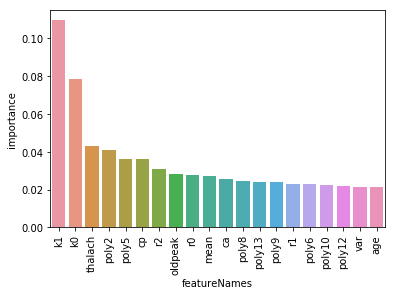

In [56]:
################## Feature selection #####################

##****************************************
## Using feature importance given by model
##****************************************

# 20. Get feature importance
clf.feature_importances_        # Column-wise feature importance
clf.feature_importances_.size   # 43


# 20.1 To our list of column names, append all other col names
#      generated by random projection, kmeans (onehotencoding)
#      and polynomial features
#      But first check if kmeans was used to generate features

if ('dummy_clusterlabels' in vars()):       # If dummy_clusterlabels labels are defined
    colNames = list(colNames) + rp_col_names+ k_means_names + poly_names
else:
    colNames = colNames = list(colNames) + rp_col_names +  poly_names      # No kmeans      <==

# 20.1.1 So how many columns?
len(colNames)           # 43 with kmeans else 21

# 20.2 Create a dataframe of feature importance and corresponding
#      column names. Sort dataframe by importance of feature
feat_imp = pd.DataFrame({
                   "importance": clf.feature_importances_ ,
                   "featureNames" : colNames
                  }
                 ).sort_values(by = "importance", ascending=False)


feat_imp.shape                   # 43 X 2 ; without kmeans: (21,2)
feat_imp.head(20)


# 20.3 Plot feature importance for first 20 features
g = sns.barplot(x = feat_imp.iloc[  : 20 ,  1] , y = feat_imp.iloc[ : 20, 0])
g.set_xticklabels(g.get_xticklabels(),rotation=90)

In [57]:
######### All the code below works  ###################


# 21   Select top 13 columns and get their indexes
#      Note that in the selected list few kmeans
#      columns also exist
newindex = feat_imp.index.values[:13]
newindex


# 22 Use these top 13 columns for classification
# 22.1  Create classifier object
clf = dt(min_samples_split = 5, min_samples_leaf= 5)
# 22.2 Traion the object on data
start = time.time()
clf = clf.fit(X_train[: , newindex], y_train)
end = time.time()
(end-start)/60                     # 1 minute


# 22.3  Make prediction
classes = clf.predict(X_test[: , newindex])
# 22.4 Accuracy?
(classes == y_test).sum()/y_test.size

0.875